In [11]:
import scipy.stats
import seaborn as sns
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import pandas as pd
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import Adam

from cities.utils.data_grabber import (
    DataGrabber,
    list_available_features,
    list_tensed_features,
)

from cities.modeling.modeling_utils import prep_wide_data_for_inference

In [12]:
outcome_dataset = "gdp"
intervention_dataset = "spending_commerce" 

tensed_covariates_datasets = [
    var
    for var in list_tensed_features()
    if var not in [outcome_dataset, intervention_dataset]
]
fixed_covariates_datasets = [
    var
    for var in list_available_features()
    if var
    not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]
]

features_needed = [
    outcome_dataset,
    intervention_dataset,
] + fixed_covariates_datasets

print(fixed_covariates_datasets)

['age_composition', 'burdens_energy', 'burdens_housing', 'diesel_matter_exposure', 'ethnic_composition', 'expected_agricultural_loss_rate', 'expected_building_loss_rate', 'expected_population_loss_rate', 'hazard', 'homeownership_rate', 'income_distribution', 'industry', 'median_owner_occupied_home_value', 'median_rent', 'proximity_to_hazardous_waste_sites', 'proximity_to_risk_management_plan_facilities', 'transport', 'urbanization']


In [13]:
cleaned_data = prep_wide_data_for_inference(
    outcome_dataset = "gdp",
intervention_dataset = "spending_commerce",
forward_shift= 3)

covariates = cleaned_data['covariates_df'].iloc[:, 2:]

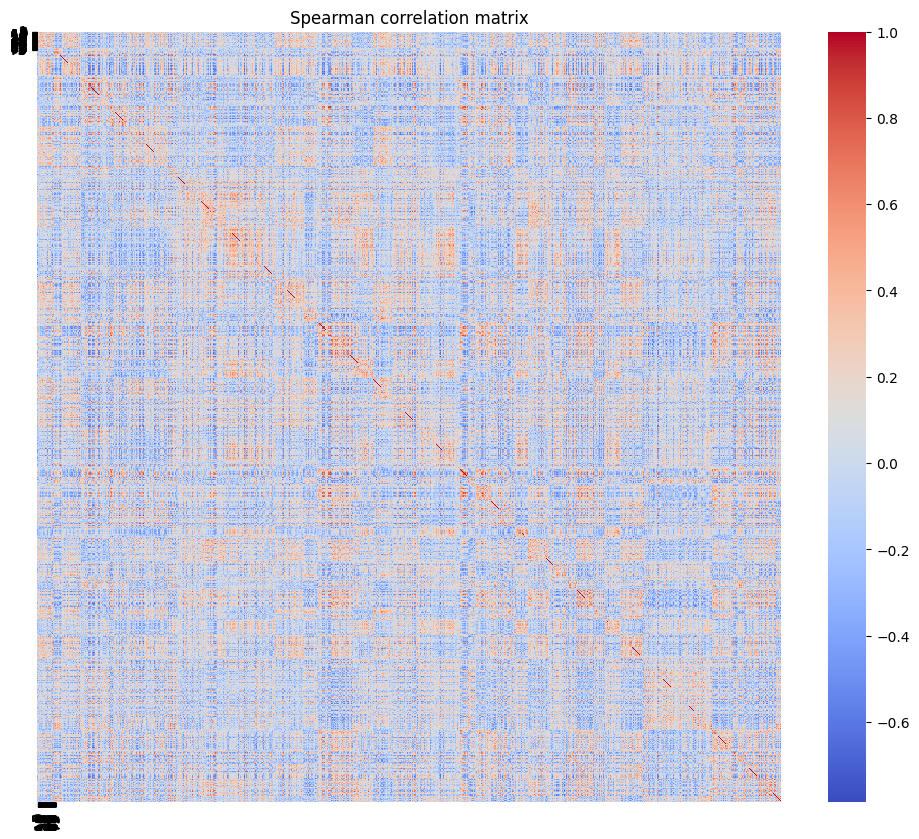

In [14]:
spearman_corr, _ = scipy.stats.spearmanr(covariates, axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=False, fmt=".2f", cmap="coolwarm", xticklabels=range(1, 76), yticklabels=range(1, 76))
plt.title("Spearman correlation matrix")
plt.show()

In [18]:

print(covariates.shape)

def drop_high_correlation(df, threshold=0.85):
    df_var = df.iloc[:,2:].copy()
    correlation_matrix, _ = spearmanr(df_var)

    high_correlation_pairs = [(df_var.columns[i], df_var.columns[j])
                              for i in range(df_var.shape[1])
                              for j in range(i + 1, df_var.shape[1])
                              if abs(correlation_matrix[i, j]) > threshold and abs(correlation_matrix[i, j]) < 1.0]
    high_correlation_pairs = [(var1, var2) for var1, var2 in high_correlation_pairs if var1 != var2]

    removed = set()
    print(f"Highly correlated pairs: {high_correlation_pairs}, second elements will be dropped")
    for var1, var2 in high_correlation_pairs:
        assert var2 in df_var.columns
    for var1, var2 in high_correlation_pairs:
        if var2 in df_var.columns:
            removed.add(var2)
            df_var.drop(var2, axis =1, inplace=True)

    result = pd.concat([df.iloc[:, :2], df_var], axis=1)
    print(f"Removed {removed} due to correlation > {threshold}")
    return result

df = drop_high_correlation(cleaned_data['covariates_df'], threshold = .85)

display(df)

(3071, 75)
Highly correlated pairs: [('expected_agricultural_loss_rate', 'Expected_agricultural_loss_rate'), ('expected_building_loss_rate', 'Expected_building_loss_rate'), ('roadDensity', 'HOUDEN_COU'), ('POPDEN_RUR', 'HOUDEN_COU'), ('POPDEN_RUR', 'HOUDEN_RUR'), ('HOUDEN_COU', 'HOUDEN_RUR'), ('HOUDEN_COU', 'ALAND_PCT_RUR')], second elements will be dropped
Removed {'Expected_building_loss_rate', 'HOUDEN_RUR', 'Expected_agricultural_loss_rate', 'HOUDEN_COU', 'ALAND_PCT_RUR'} due to correlation > 0.85


,GeoFIPS,GeoName,under_5,5_to_9,10_to_14,15_to_19,20_to_24,25_to_29,30_to_34,35_to_39,...,other_services,public_admin,median_owner_occupied_home_value,median_rent,proximity_to_hazardous_waste_sites,proximity_to_risk_management_plan_facilities,roadDensity,WeightAvgNatWalkInd,POPDEN_RUR,POPDEN_URB
0,1001,"Autauga, AL",-0.001159,0.037745,0.042455,0.028727,0.026881,0.056710,0.078574,0.167473,...,0.010899,0.189360,-0.004929,0.174091,0.041139,-0.132132,-0.050714,-0.086894,0.000583,0.034206
1,1003,"Baldwin, AL",-0.050624,-0.119720,0.087384,-0.051790,-0.073441,-0.062570,-0.034426,0.056219,...,0.001346,-0.022927,0.092599,0.179307,-0.010034,-0.123896,-0.017482,0.031440,0.069679,-0.010885
2,1005,"Barbour, AL",-0.059646,0.032259,-0.118252,-0.073884,-0.017056,0.135607,0.169641,0.113273,...,-0.094989,0.084343,-0.123798,-0.146097,-0.067982,-0.073164,-0.085156,-0.115758,-0.085991,0.015236
3,1007,"Bibb, AL",-0.045949,-0.052662,-0.136285,0.001097,-0.043892,0.268472,0.130443,0.164338,...,0.252262,-0.015852,-0.102833,-0.053554,-0.025047,-0.148778,-0.054332,-0.108261,-0.021993,-0.095445
4,1009,"Blount, AL",0.022521,-0.001778,0.074376,-0.049194,-0.011581,0.039297,-0.014028,-0.071117,...,0.061795,-0.116591,-0.047371,-0.089037,-0.043455,-0.134494,0.003985,-0.157911,0.158067,0.007681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,56037,"Sweetwater, WY",0.068379,0.260246,0.069481,0.068740,-0.000382,0.020523,0.155022,0.272980,...,-0.252365,0.034308,0.077966,0.023784,0.061277,-0.058903,-0.135422,0.109553,-0.155191,0.062076
3067,56039,"Teton, WY",-0.139054,-0.213008,-0.028713,-0.186820,-0.139136,0.344571,0.423715,0.384821,...,0.131572,-0.153260,0.843157,0.439267,-0.071640,-0.155852,-0.146052,0.072727,-0.145121,0.201548
3068,56041,"Uinta, WY",0.145730,0.285015,0.258467,-0.005820,-0.052654,-0.043589,0.078790,0.305794,...,0.092294,-0.036960,0.036265,-0.075668,-0.062655,0.021703,-0.114556,0.017156,-0.140622,0.023884
3069,56043,"Washakie, WY",-0.070706,-0.249079,0.161002,0.188844,-0.069984,-0.134807,-0.183068,-0.107857,...,0.299208,0.095454,0.016943,-0.135542,-0.071640,-0.121175,-0.130899,0.086277,-0.152171,0.036467
